In [1]:
from collections import Counter
import re
from string import ascii_lowercase

import pandas as pd
from tqdm import tqdm

## Functions & Setup

In [2]:
class HangmanWordList:
    
    def __init__(self, full_word_list):
        self.full_word_list = full_word_list
        self.valid_words = full_word_list
    
    def reset_word_list(self):
        """
        Return valid_words to contain all words in the list. Needed for
        when the same HangmanWordList is reused on consecutive games.
        """
        self.valid_words = self.full_word_list
    
    def filter_valid_words_by_length(self, length):
        """
        Removes entries from valid_words that don't match the specified
        length (should be the length of the goal word).
        """
        self.valid_words = [w for w in self.valid_words if len(w) == length]
    
    def filter_by_known_letters(self, solution_list):
        """
        Removes words that don't match the pattern.
        """
        solution = "^" + "".join(solution_list) + "$"
        self.valid_words = [w for w in self.valid_words if re.match(solution, w)]
    
    def most_common_letter_by_count(self, used_letters=[]):
        """
        Return the list of letters not in used_letters, ordered by
        the number of appearances they have in valid_words.
        """
        all_words_string = ''.join(self.valid_words)
        all_words_letter_count = Counter(all_words_string)
        for l in used_letters:
            all_words_letter_count.pop(l, None)
        return all_words_letter_count.most_common()
    
    def most_common_letter_by_words(self, used_letters=[]):
        """
        Return the list of letters not in used_letters, ordered by
        the fraction of entries in valid_words that they appear in.
        """
        possible_letters = [l for l in ascii_lowercase if l not in used_letters]
        letter_in_word_freq = {l:sum([1 for w in self.valid_words if l in w]) for l in possible_letters}
        return Counter(letter_in_word_freq).most_common()

In [3]:
def indices_in_word(letter, goal_word):
    """Get indices of a letter in a word."""
    indices = []
    i = goal_word.find(letter)
    while i != -1:
        indices.append(i)
        i = goal_word.find(letter, i+1)
    return indices

Read in the word list from the text file from here: https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt

In [2]:
# read words, filter down to just those with 3 to 20 letters
with open("words_alpha.txt", "r") as f:
    words = f.readlines()
words = [w.strip() for w in words]
words = [w for w in words if 20 >= len(w) >= 3]

Precompute a bunch of the necessary word lists and most common letter lists (it saved a lot computation time).

In [4]:
word_list = HangmanWordList(words)

In [5]:
CASE_1_LETTERS = word_list.most_common_letter_by_count()
CASE_4_LETTERS = word_list.most_common_letter_by_words()

In [6]:
CASE_2_LETTERS = {}
CASE_5_LETTERS = {}
for l in range(3,21):
    word_list.filter_valid_words_by_length(l)
    CASE_2_LETTERS[l] = word_list.most_common_letter_by_count()
    CASE_5_LETTERS[l] = word_list.most_common_letter_by_words()
    word_list.reset_word_list()

In [7]:
CASE_3_6_WORD_LISTS = {}
for l in range(3,21):
    CASE_3_6_WORD_LISTS[l] = HangmanWordList([w for w in words if len(w) == l])

## Game Types

In [8]:
## CASE 1: guess on full corpus, most common by count of all letters
def case_1_game(goal_word):
    solution = ["."] * len(goal_word)
    guesses = []
    while "." in solution:
        next_guess = CASE_1_LETTERS[len(guesses)][0]
        if next_guess in goal_word:
            letter_indices = indices_in_word(next_guess, goal_word)
            for li in letter_indices:
                solution[li] = next_guess
        guesses.append(next_guess)
    return guesses

In [9]:
%timeit -n 10000 case_1_game("tithe")

4.11 µs ± 854 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
## CASE 2: guess on words of same length, most common by count of all letters
def case_2_game(goal_word):
    solution = ["."] * len(goal_word)
    guesses = []
    while "." in solution:
        next_guess = CASE_2_LETTERS[len(goal_word)][len(guesses)][0]
        if next_guess in goal_word:
            letter_indices = indices_in_word(next_guess, goal_word)
            for li in letter_indices:
                solution[li] = next_guess
        guesses.append(next_guess)
    return guesses

In [11]:
%timeit -n 100000 case_2_game("tithe")

4.35 µs ± 135 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
## CASE 3: guess on words of same length & pattern, most common by count of all letters
def case_3_game(goal_word, word_list):
    word_list.reset_word_list()
    solution = ["."] * len(goal_word)
    guesses = []
    while "." in solution:
        word_list.filter_by_known_letters(solution)
        next_guess = word_list.most_common_letter_by_count(guesses)[0][0]
        if next_guess in goal_word:
            letter_indices = indices_in_word(next_guess, goal_word)
            for li in letter_indices:
                solution[li] = next_guess
        guesses.append(next_guess)
    return guesses

In [13]:
%timeit -n 10 case_3_game("tithe", CASE_3_6_WORD_LISTS[5])

35.8 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
## CASE 4: guess on full corpus, most common by % of words
def case_4_game(goal_word):
    solution = ["."] * len(goal_word)
    guesses = []
    while "." in solution:
        next_guess = CASE_4_LETTERS[len(guesses)][0]
        if next_guess in goal_word:
            letter_indices = indices_in_word(next_guess, goal_word)
            for li in letter_indices:
                solution[li] = next_guess
        guesses.append(next_guess)
    return guesses

In [15]:
%timeit -n 100000 case_4_game("tithe")

3.7 µs ± 60.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [16]:
## CASE 5: guess on words of same length, most common by % of words
def case_5_game(goal_word):
    solution = ["."] * len(goal_word)
    guesses = []
    while "." in solution:
        next_guess = CASE_5_LETTERS[len(goal_word)][len(guesses)][0]
        if next_guess in goal_word:
            letter_indices = indices_in_word(next_guess, goal_word)
            for li in letter_indices:
                solution[li] = next_guess
        guesses.append(next_guess)
    return guesses

In [17]:
%timeit -n 100000 case_5_game("tithe")

4.1 µs ± 40.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:
## CASE 6: guess on words of same length & pattern, most common by % of words
def case_6_game(goal_word, word_list):
    word_list.reset_word_list()
    solution = ["."] * len(goal_word)
    guesses = []
    while "." in solution:
        word_list.filter_by_known_letters(solution)
        next_guess = word_list.most_common_letter_by_words(guesses)[0][0]
        if next_guess in goal_word:
            letter_indices = indices_in_word(next_guess, goal_word)
            for li in letter_indices:
                solution[li] = next_guess
        guesses.append(next_guess)
    return guesses

## Make the Guesses

In [ ]:
guess_tuples = []
for w in tqdm(word_list.full_word_list):
    guesses1 = case_1_game(w)
    guesses2 = case_2_game(w)
    guesses3 = case_3_game(w, CASE_3_6_WORD_LISTS[len(w)])
    guesses4 = case_4_game(w)
    guesses5 = case_5_game(w)
    guesses6 = case_6_game(w, CASE_3_6_WORD_LISTS[len(w)])
    guess_tuples.append((w, len(guesses1), len(guesses2), len(guesses3), len(guesses4), len(guesses5), len(guesses6)))

 87%|████████▋ | 321149/369349 [16:17:57<2:14:20,  5.98it/s] 

In [1]:
import pandas as pd

In [24]:
## convert to dataframe, relabel columns, dump to CSV so we don't have to rerun the above later
hangman_df = pd.DataFrame.from_records(guess_tuples)
hangman_df.columns = ["Word", "Case1Guesses", "Case2Guesses", "Case3Guesses",
                      "Case4Guesses", "Case5Guesses", "Case6Guesses"]
hangman_df.to_csv("hangman.csv")

In [3]:
## load the CSV and add some columns
hangman_df = pd.read_csv("hangman.csv", index_col=0)
hangman_df["WordLength"] = [len(w) for w in words]
hangman_df["UniqueLettersInWord"] = [len(set(w)) for w in words]

In [8]:
hangman_df

,Word,Case1Guesses,Case2Guesses,Case3Guesses,Case4Guesses,Case5Guesses,Case6Guesses,WordLength,UniqueLettersInWord
0,aaa,3,1,1,3,1,1,3,1
1,aah,15,17,2,15,17,2,3,2
2,aahed,15,16,4,15,15,4,5,4
3,aahing,16,16,6,16,16,6,6,5
4,aahs,15,15,3,15,15,3,4,3
...,...,...,...,...,...,...,...,...,...
369344,zwinglianism,23,24,10,23,24,9,12,9
369345,zwinglianist,23,24,11,23,24,10,12,9
369346,zwitter,23,23,8,23,23,8,7,6
369347,zwitterion,23,23,11,23,23,8,10,8


## Analysis

In [4]:
import seaborn as sns
sns.set(rc={'figure.figsize':(9,6)})
sns.set_theme(style="darkgrid")

In [5]:
## question 1: difference in "most common" methods
x1 = 100*(hangman_df["Case1Guesses"]-hangman_df["Case4Guesses"])\
    .value_counts().sort_index()/len(hangman_df)

x2 = 100*(hangman_df["Case2Guesses"]-hangman_df["Case5Guesses"])\
    .value_counts().sort_index()/len(hangman_df)

x3 = 100*(hangman_df["Case3Guesses"]-hangman_df["Case6Guesses"])\
    .value_counts().sort_index()/len(hangman_df)

q1 = pd.DataFrame({"AllWords":x1, "SameLengthWords":x2, "LengthAndPattern":x3}).fillna(0)

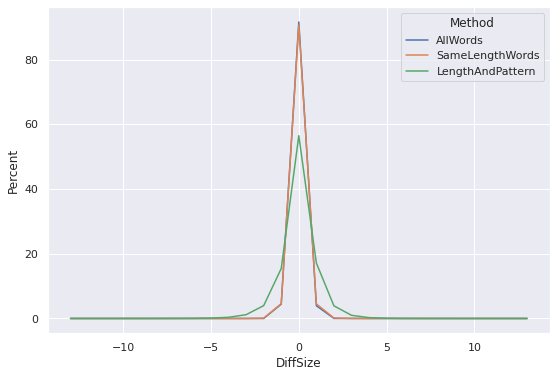

In [6]:
q1_df = q1.stack().reset_index()
q1_df.columns = ["DiffSize", "Method", "Percent"]

method_diff_plot = sns.lineplot(data=q1_df, x="DiffSize", y="Percent", hue="Method")
method_diff_plot.get_figure().savefig("method_diff_plot.png")

In [66]:
## question 2: difference between guess counts for "use all words" & "use words of same length"
question2_dict1 = {"LetterCount": 100*(hangman_df["Case1Guesses"]-hangman_df["Case2Guesses"])\
    .value_counts().sort_index()/len(hangman_df),
                 "MostWords": 100*(hangman_df["Case4Guesses"]-hangman_df["Case5Guesses"])\
    .value_counts().sort_index()/len(hangman_df)}

In [67]:
q2 = pd.DataFrame(question2_dict1).fillna(0).round(3)
q2

,LetterCount,MostWords
-9,0.004,0.000
-8,0.003,0.006
-7,0.003,0.004
-6,0.002,0.003
-5,0.028,0.003
-4,0.077,0.180
-3,0.664,0.706
-2,6.873,5.105
-1,15.190,16.101
0,46.773,49.465


In [68]:
q2 = q2.stack().reset_index()
q2.columns = ["DiffSize", "MostCommonMethod", "Percent"]

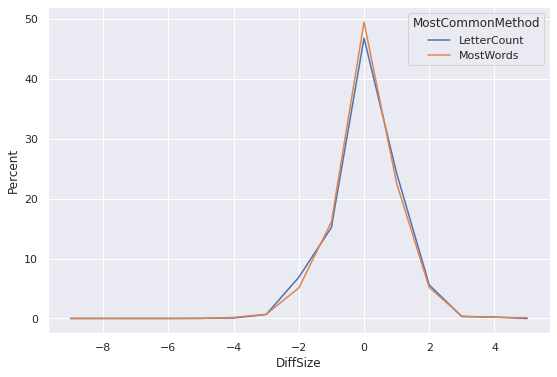

In [69]:
q2_plot = sns.lineplot(data=q2, x="DiffSize", y="Percent", hue="MostCommonMethod")
q2_plot.get_figure().savefig("q2_plot.png")

In [56]:
# looking for percentage that require more guesses in cases 2/5 versus cases 1/4 
q2_df = pd.DataFrame({"WordLength":hangman_df["WordLength"],
                      "LetterCount":hangman_df["Case1Guesses"]-hangman_df["Case2Guesses"] < 0,
                      "MostWords":hangman_df["Case4Guesses"]-hangman_df["Case5Guesses"] < 0})
q2_df.groupby("WordLength").agg(lambda x: 100*x.mean()).round(3)

,LetterCount,MostWords
WordLength,,
3,33.521,34.460
4,30.170,37.782
5,43.020,36.801
6,35.462,36.584
7,32.506,38.140
8,31.001,23.073
9,22.115,22.141
10,3.926,0.037
11,0.008,3.229


In [74]:
## question 3: "words of same length" vs "words of same length and pattern"
q3_dict1 = {"LetterCount": 100*(hangman_df["Case2Guesses"]-hangman_df["Case3Guesses"])\
    .value_counts().sort_index()/len(hangman_df),
            "MostWords": 100*(hangman_df["Case5Guesses"]-hangman_df["Case6Guesses"])\
    .value_counts().sort_index()/len(hangman_df)}

In [75]:
q3 = pd.DataFrame(q3_dict1).fillna(0).round(3)
q3

,LetterCount,MostWords
-18,0.000,0.000
-14,0.000,0.001
-13,0.001,0.001
-12,0.003,0.000
-11,0.003,0.004
-10,0.006,0.006
-9,0.009,0.008
-8,0.012,0.013
-7,0.022,0.019
-6,0.041,0.039


In [76]:
q3 = q3.stack().reset_index()
q3.columns = ["DiffSize", "MostCommonMethod", "Percent"]

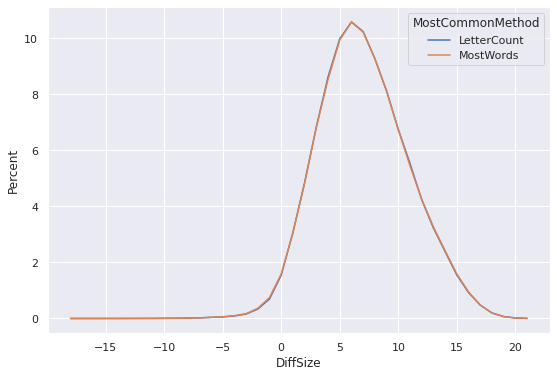

In [77]:
q3_plot = sns.lineplot(data=q3, x="DiffSize", y="Percent", hue="MostCommonMethod")
q3_plot.get_figure().savefig("q3_plot.png")

In [60]:
## percentage of words that need more guesses in case 3/6 than 2/5
q3_df1 = pd.DataFrame({"WordLength":hangman_df["WordLength"],
                       "LetterCount":hangman_df["Case2Guesses"]-hangman_df["Case3Guesses"] < 0,
                       "MostWords":hangman_df["Case5Guesses"]-hangman_df["Case6Guesses"] < 0})
q3_df1.groupby("WordLength").agg(lambda x: 100*x.mean()).round(3)

,LetterCount,MostWords
WordLength,,
3,20.516,19.484
4,11.773,11.703
5,6.087,6.119
6,3.404,3.625
7,1.910,2.129
8,1.021,1.199
9,0.642,0.777
10,0.377,0.449
11,0.234,0.272


In [87]:
## question 4: win percentages
counts_list = []
for x in range(1,7):
    subset_df = hangman_df[["WordLength",f"Case{x}Guesses","UniqueLettersInWord"]].copy()
    num_wrong_guesses = subset_df[f"Case{x}Guesses"] - subset_df["UniqueLettersInWord"]
    percent_wins = 100*(num_wrong_guesses <= 5).mean()
    counts_list.append((f"Case{x}", percent_wins))
    
pd.DataFrame.from_records(counts_list, columns=["Case", "PercentageWon"])

,Case,PercentageWon
0,Case1,14.647122
1,Case2,14.680424
2,Case3,87.136286
3,Case4,14.622484
4,Case5,14.724285
5,Case6,87.076180
